In [2]:
import keras
import os
import cv2
import scipy
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from keras.layers import Input, Dense, Dropout, Flatten, Conv2D, MaxPool2D, Activation, BatchNormalization, SpatialDropout2D
from keras.models import Model
from keras import optimizers

Using TensorFlow backend.


In [3]:
from keras.utils.generic_utils import get_custom_objects
from keras import backend as K

def swish(x):
    return (K.sigmoid(x) * x)

get_custom_objects().update({'swish': Activation(swish)})

In [4]:
# What data should we load?
# What to do with unlabeled data?
def get_data(folder):
    X, y, z = [], [], []
    wbc_types = {'NEUTROPHIL': (0,1), 'EOSINOPHIL': (1,1), 'MONOCYTE': (2,0), 'LYMPHOCYTE': (3,0)}
    for (wbc_type, labels) in wbc_types.items():  
        for image_filename in tqdm(os.listdir(folder + wbc_type)):
            img_file = cv2.imread(folder + wbc_type + '/' + image_filename)
            if img_file is not None:
                    img_file = scipy.misc.imresize(arr=img_file, size=(60, 80, 3))
                    img_arr = np.asarray(img_file)
                    X.append(img_arr)
                    y.append(labels[0])
                    z.append(labels[1])
    X = np.asarray(X)
    y = np.asarray(y)
    z = np.asarray(z)
    return X,y,z

from keras.utils.np_utils import to_categorical

X_train, y_train, z_train = get_data("blood-cells/dataset2-master/images/TRAIN/")
X_test, y_test, z_test = get_data("blood-cells/dataset2-master/images/TEST/")
y_trainHot = to_categorical(y_train, num_classes = 4)
y_testHot = to_categorical(y_test, num_classes = 4)
z_trainHot = to_categorical(z_train, num_classes = 2)
z_testHot = to_categorical(z_test, num_classes = 2)

X_train_original, y_train_original, z_train_original = get_data("blood-cells/dataset2-master/images/TRAIN/")
X_test, y_test, z_test = get_data("blood-cells/dataset2-master/images/TEST/")
y_trainHot = to_categorical(y_train, num_classes = 4)
y_testHot = to_categorical(y_test, num_classes = 4)
z_trainHot = to_categorical(z_train, num_classes = 2)
z_testHot = to_categorical(z_test, num_classes = 2)

  0%|          | 0/2499 [00:00<?, ?it/s]/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/misc/pilutil.py:480: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if issubdtype(ts, int):
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/misc/pilutil.py:483: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif issubdtype(type(size), float):
100%|██████████| 620/620 [00:02<00:00, 289.96it/s]


In [19]:
def plot_images(imgs, images_per_row=1, color=True):
    width=60
    height=80
    images_per_row = min(len(imgs), images_per_row)
    if color:
        images = [instance.reshape(width,height, 3) for instance in imgs]
    else:
        images = [instance.reshape(width,height) for instance in imgs]
    n_rows = (len(imgs) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(imgs)
    if color:
        images.append(np.zeros((width, height * n_empty, 3)))
    else:
        images.append(np.zeros((width, height * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = plt.cm.binary)
    plt.axis("off")

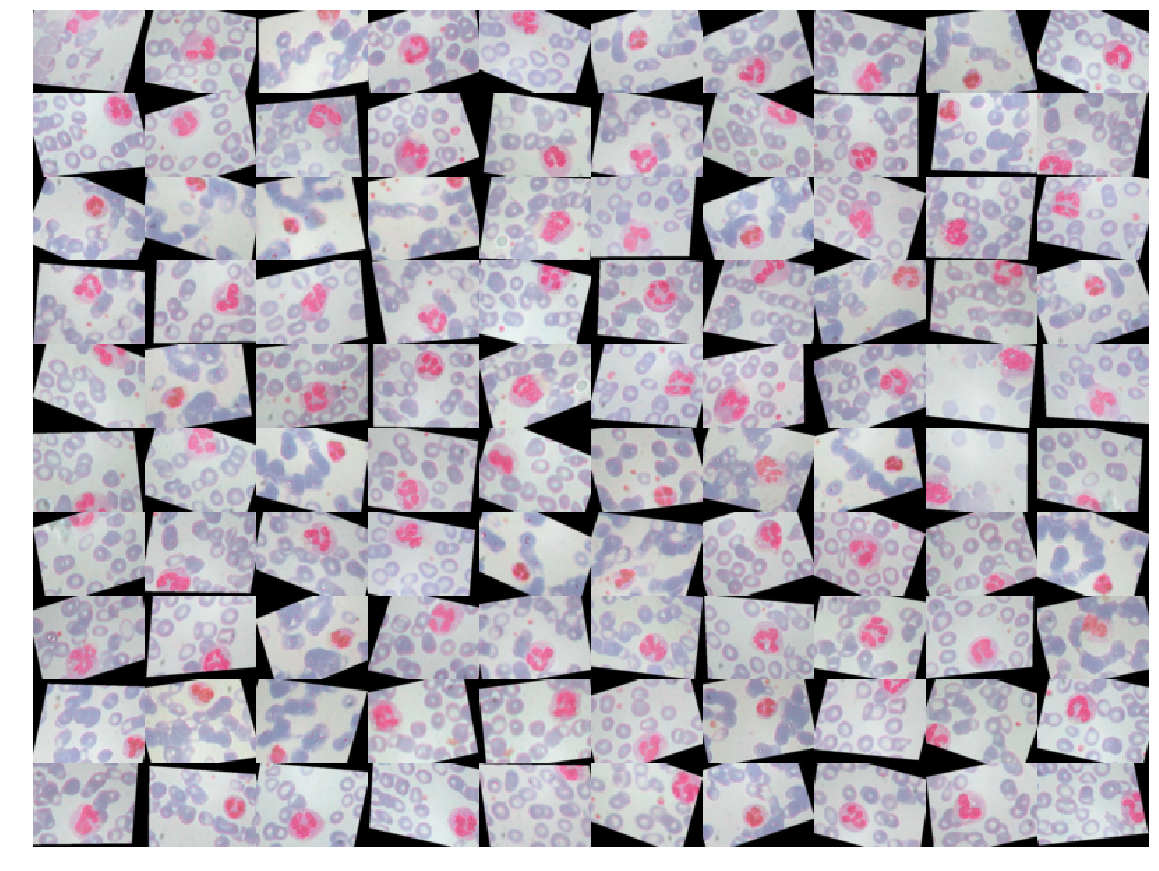

In [17]:
# data visualization etc.
from matplotlib import pyplot as plt

figure = plt.figure(figsize=(20,20))
plot_images(X_train[0:100], images_per_row=10)
plt.show()

# mean image
# std image
# count plot
# covariance matrix
# svd of covariance matrix
# show a few examples of what the data looks like

# preprocessing?

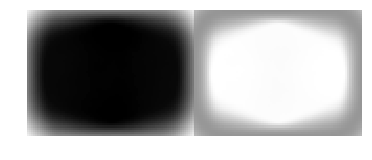

In [40]:
def gray(img):
    return np.average(img, weights=[0.299, 0.587, 0.114], axis=2).reshape(60,80,1)

X_train_grayscale = np.array([gray(xi) for xi in X_train])
X_test_grayscale = np.array([gray(xi) for xi in X_test])

# plt.imshow(np.mean(X_train_grayscale, axis=0))
# plt.imshow(np.std(X_train_grayscale, axis=0))
plot_images([np.mean(X_train_grayscale, axis=0), np.std(X_train_grayscale, axis=0)], images_per_row=2, color=False)
plt.show()

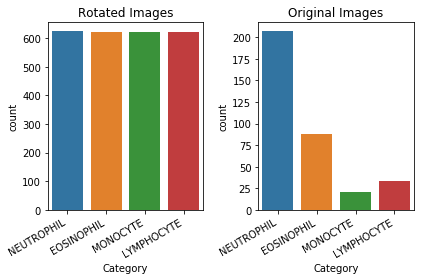

In [11]:
# fig1, ax1 = plt.subplots()
# ax1.bar(range(4), height=list(map(lambda x: list(y_train).count(x), range(4))))
# fig2, ax2 = plt.subplots()
# ax2.bar(range(4), height=list(map(lambda x: list(y_test).count(x), range(4))))
types = ['NEUTROPHIL', 'EOSINOPHIL', 'MONOCYTE', 'LYMPHOCYTE']
ax1 = plt.subplot(1, 2, 1)
fig1 = sns.countplot(list(map(lambda x: types[x], y_test)))
fig1.set_title("Rotated Images")
fig1.set_xlabel("Category")

ax2 = plt.subplot(1, 2, 2)
rdl = pd.read_csv("blood-cells/dataset-master/labels.csv")
fig2 = sns.countplot(x="Category", data=rdl.loc[rdl['Category'].isin(types)])
fig2.set_title("Original Images")

plt.setp(ax1.get_xticklabels(), rotation=30, horizontalalignment='right')
plt.setp(ax2.get_xticklabels(), rotation=30, horizontalalignment='right')

plt.tight_layout()
plt.show()

In [31]:
# swish vs relu vs other stuff? maybe softmax?
# more normalization?
# more fully connected layers?
# more Conv layers?
# more dropout layers?
# other types of regularizaton? Dropconnect? Bayes by backprop? L1/L2?
# other normalization techniques?
# other optimizers? change learning rate as we go?
# more complicated network structures? bounding box?
def build_model(*args, **kwargs):
    inp = Input(shape=(60,80,1))
    x = BatchNormalization()(inp)
    x = Conv2D(16, 7, strides=(2,  2), padding='same', activation='relu')(x)
    x = MaxPool2D(pool_size=(2, 2), padding="valid", strides=(2,2))(x)
    x = BatchNormalization()(x)
    x = Conv2D(16, 1, strides=(1, 1), padding='same', activation='relu')(x)
    x = Conv2D(32, 3, strides=(1, 1), padding='same', activation='relu')(x)
    x = Flatten()(x)
    y = Dense(4, activation='softmax')(x)
    
    model = Model(inp, y)
    opt = optimizers.Adam(lr=0.01, decay=0.0001)
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    return model

model = build_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 60, 80, 1)         0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 60, 80, 1)         4         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 30, 40, 16)        800       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 15, 20, 16)        0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 15, 20, 16)        64        
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 15, 20, 16)        272       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 15, 20, 32)        4640      
__________

In [42]:
# train model
h = model.fit(X_train, y_trainHot, epochs=10, batch_size=32, validation_data=(X_test, y_testHot), verbose=1)
# save model
# better validation set (do not use test set)

Train on 9957 samples, validate on 2487 samples
Epoch 1/10
9957/9957 [==============================] - 22s 2ms/step - loss: 1.0326 - acc: 0.5633 - val_loss: 1.2569 - val_acc: 0.4150
Epoch 2/10
9957/9957 [==============================] - 21s 2ms/step - loss: 0.8176 - acc: 0.6730 - val_loss: 1.4554 - val_acc: 0.3788
Epoch 3/10
9957/9957 [==============================] - 20s 2ms/step - loss: 0.6285 - acc: 0.7570 - val_loss: 1.5142 - val_acc: 0.4101
Epoch 4/10
9957/9957 [==============================] - 20s 2ms/step - loss: 0.4874 - acc: 0.8179 - val_loss: 1.5089 - val_acc: 0.4507
Epoch 5/10
9957/9957 [==============================] - 20s 2ms/step - loss: 0.3758 - acc: 0.8655 - val_loss: 1.7361 - val_acc: 0.4447
Epoch 6/10
9957/9957 [==============================] - 21s 2ms/step - loss: 0.2849 - acc: 0.8991 - val_loss: 1.9322 - val_acc: 0.4206
Epoch 7/10
9957/9957 [==============================] - 22s 2ms/step - loss: 0.2289 - acc: 0.9192 - val_loss: 2.0831 - val_acc: 0.4443
Epoch 8

In [25]:
# test model (on completely unseen data)
model.evaluate(X_test, y_testHot, batch_size=128)

# nice plots etc
# examples of correct and wrong predictions
# confusion matrix

NameError: name 'model' is not defined

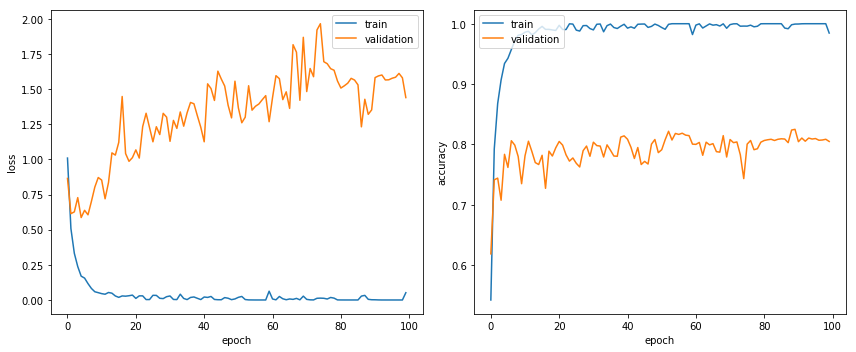

In [113]:
def plot_history(h):
    f = plt.figure(figsize=(12,5))
    ax1 = plt.subplot(1,2,1)
    ax1.plot(h.history['loss'])
    ax1.plot(h.history['val_loss'])
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper right')
    ax2 = plt.subplot(1,2,2)
    ax2.plot(h.history['acc'])
    ax2.plot(h.history['val_acc'])
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.tight_layout()
    plt.show()
    
plot_history(h)

In [1]:
from sklearn.metrics import confusion_matrix
pred = model.predict(X_test)
mpred = np.argmax(pred, axis=1)
conf_mx = confusion_matrix(y_test, mpred)
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

NameError: name 'model' is not defined

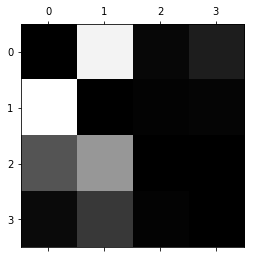

In [115]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

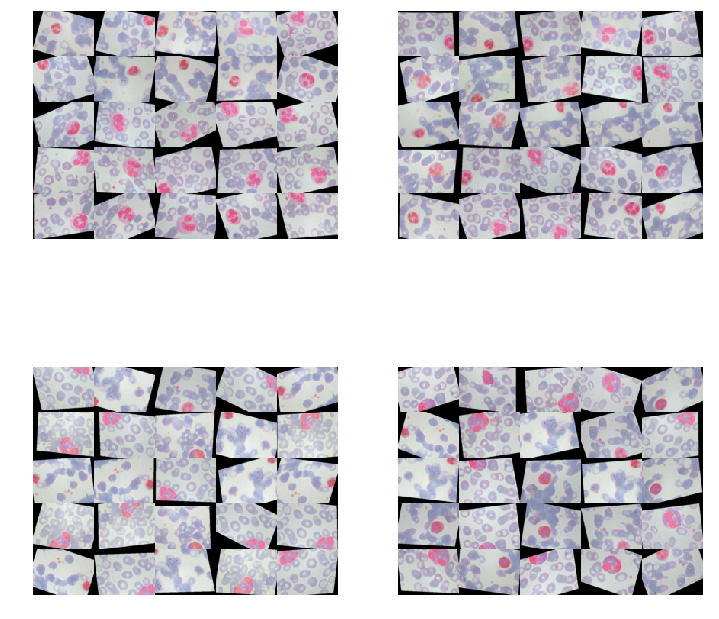

In [117]:
cl_a, cl_b = 0, 1
x_aa = X_test[(y_test == cl_a) & (mpred == cl_a)]
x_ab = X_test[(y_test == cl_a) & (mpred == cl_b)]
x_ba = X_test[(y_test == cl_b) & (mpred == cl_a)]
x_bb = X_test[(y_test == cl_b) & (mpred == cl_b)]

plt.figure(figsize=(12,12))
plt.subplot(2,2,1);  plot_images(x_aa[:25], images_per_row=5)
plt.subplot(2,2,2);  plot_images(x_ab[:25], images_per_row=5)
plt.subplot(2,2,3);  plot_images(x_ba[:25], images_per_row=5)
plt.subplot(2,2,4);  plot_images(x_bb[:25], images_per_row=5)
plt.show()

In [120]:
from sklearn.metrics import f1_score, precision_score, recall_score
print('f1 score:', f1_score(y_test, mpred, average="macro"))
print('precision:', precision_score(y_test, mpred, average="macro"))
print('recall:', recall_score(y_test, mpred, average="macro"))

f1 score: 0.8105182092311198
precision: 0.8241824481244149
recall: 0.8051422450933143


In [160]:
print('f1 score:', f1_score(y_test > 1, mpred > 1, average="macro"))
print('precision:', precision_score(y_test > 1, mpred > 1, average="macro"))
print('recall:', recall_score(y_test > 1, mpred > 1, average="macro"))

f1 score: 0.9200835475578406
precision: 0.9263797441109963
recall: 0.9202201412422071


In [ ]:
from sklearn.decomposition  import PCA
pca = PCA(n_components=2)
X_train_flat = X_train[:25].reshape(25*80*60, 3).T
pca.fit(X_train_flat)

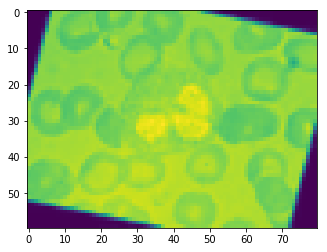

In [186]:
plt.imshow(X_train[1][:,:,2])
plt.show()

In [151]:
a = np.array([[1,1], [2,2]])
print(a)
a.ravel()
a.reshape(2,2)

[[1 1]
 [2 2]]


array([[1, 1],
       [2, 2]])

In [201]:
X_train.reshape(47793600, 3)
z = np.count_nonzero(X_train.reshape(47793600, 3) == [0,0,0])
nz = np.count_nonzero(X_train.reshape(47793600, 3) != [0,0,0])
z / (z + nz)

0.08629734943590774

In [ ]:
a